## Antipsychotic outlier prescribing

This notebook identifies practices as part of our outlier detection who prescribed promazine and pericyazine.

In [1]:
#import libraries required for analysis
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from ebmdatalab import bq, charts, maps
import glob
import geopandas as gpd
import matplotlib.gridspec as gridspec
from pathlib import Path
import warnings


#### Data Extract

Here we identify all promazine prescribing.

In [2]:
sql = """
SELECT
pct,
ccgs.name as ccg_name,
practice,
prac.name,
SUM(CASE WHEN bnf_code LIKE '0402010S0%' then items ELSE 0 END) as total_promazine,
SUM(CASE WHEN bnf_code LIKE '0402010P0%' then items ELSE 0 END) as total_pericyazine, 
SUM(items) AS total_antipsy
FROM ebmdatalab.hscic.all_prescribing AS presc
INNER JOIN ebmdatalab.hscic.practices AS prac
ON
presc.practice = prac.code
AND (prac.setting = 4)
INNER JOIN ebmdatalab.hscic.ccgs AS ccgs
ON 
presc.pct = ccgs.code
WHERE
bnf_code LIKE "040201%" 
AND
(presc.month BETWEEN "2017-06-01" AND "2017-08-01")
AND 
ccgs.org_type = 'CCG'
GROUP BY
  pct,
  ccg_name,
  practice,
  prac.name
ORDER BY
  practice
"""

anti_psy = bq.cached_read(sql, csv_path='anti_psy_df.csv')

In [3]:
ccg_anti_psy = anti_psy.groupby(['pct', 'ccg_name']).sum().reset_index()
ccg_anti_psy['promazine_per_1000_items'] = 1000* (ccg_anti_psy['total_promazine']/ccg_anti_psy['total_antipsy'])
ccg_anti_psy['pericyazine_per_1000_items'] = 1000* (ccg_anti_psy['total_pericyazine']/ccg_anti_psy['total_antipsy'])
ccg_anti_psy.head(5)

,pct,ccg_name,total_promazine,total_pericyazine,total_antipsy,promazine_per_1000_items,pericyazine_per_1000_items
0,00C,NHS DARLINGTON CCG,3,8,6449,0.465188,1.240502
1,00D,"NHS DURHAM DALES, EASINGTON AND SEDGEFIELD CCG",112,0,19367,5.783033,0.000000
2,00J,NHS NORTH DURHAM CCG,5,13,12894,0.387777,1.008221
3,00K,NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG,455,0,10250,44.390244,0.000000
4,00L,NHS NORTHUMBERLAND CCG,8,0,15178,0.527079,0.000000


In [9]:
#create choropeth map of rx per 1000 antipsychotic prescriptions using bespoke map function (derived from ebmdatalab library)

def ccg_map_bespoke(
    df,
    title="",
    column=None,
    region=None,
    separate_region=False,
    region_layout="horizontal",
    cartogram=False,
    subplot_spec=None,
    show_legend=True,
    map_year=None,
    plot_options=None,
):
    """Draw a CCG map with area separated out
    """
    # Because this uses subplots to arrange London and England,
    # the only way to arrange nested subplots is via a subplotspec
    assert column, "You must specify a column name to plot"
    df = df.copy()
    # input df must have 'pct' column, plus others as specified
    data_dir = os.path.join("..","data")

    # Add names and if it's London. Note the names in ccg_for_map must
    # match names in the CCG geojson, as that doesn't include codes at
    # the momemt
    map_name = os.path.join(data_dir, "ccg_for_map.csv")
    names = pd.read_csv(map_name)

    # Check we know about all the codes in the input data
    diff = np.setdiff1d(df["pct"], names["code"])
    if len(diff) > 0:
        raise BaseException(
            "Data contains CCG codes we don't know about: {}".format(diff)
        )

    df = df.merge(names[["code", "name", "region"]], left_on="pct", right_on="code")
    df = df.set_index("name")

    # Load map data
    cartogram_suffix = ""
    if cartogram:
        cartogram_suffix = "_cartogram"
    if map_year:
        map_file = os.path.join(data_dir,"ccgs{}_{}.json").format(cartogram_suffix, map_year)
    else:
        map_file = sorted(
            glob.glob(str(os.path.join(data_dir,"ccgs{}_2*.json").format(cartogram_suffix)))
        )[-1]
    ccgs = gpd.read_file(map_file)
    # Normalise names to match `ccg_fo_map` format (above)
    ccgs["name"] = ccgs["name"].str.upper()
    ccgs = ccgs.set_index("name")
    # Remove ones without geometry - these are (usually) federations
    # rather than individual CCGs
    ccgs = ccgs[~ccgs["geometry"].isnull()]

    # Check we can map all the CCGs named in the input data
    diff = np.setdiff1d(df.index, ccgs.index)
    if len(diff) > 0:
        raise BaseException("Data contains CCG names we can't map: {}".format(diff))

    # Join map with data
    gdf = ccgs.join(df, rsuffix="_orig")

    # Split into london and rest of England
    gdf_region = gdf[gdf["region"] == region]
    gdf_roe = gdf

    # set common value limits for colour scale
    default_plot_options = {
        'vmin': df[column].min(),
        'vmax': df[column].max(),
        'edgecolor': "black",
        'linewidth': 0.1,
        'cmap': "OrRd",
    }

    if plot_options is None:
        plot_options = {}

    for k, v in default_plot_options.items():
        if k not in plot_options:
            plot_options[k] = v

    def plot(gdf, ax, title="", legend=True):
        gdf.plot(
            ax=ax,
            column=column,
            legend=legend,
            **plot_options
        )
        ax.set_aspect(1.63)
        if title:
            ax.set_title(title, size=12)
        ax.axis("off")

    fig = plt.gcf()
    if not subplot_spec:
        subplot_spec = gridspec.GridSpec(1, 1)[0]
    if separate_region:
        if region_layout == "horizontal":
            gs = gridspec.GridSpecFromSubplotSpec(
                nrows=1, ncols=2, width_ratios=[1, 2], subplot_spec=subplot_spec
            )
            ldn_ax = fig.add_subplot(gs[0, 0])
            roe_ax = fig.add_subplot(gs[0, 1])
        else:
            gs = gridspec.GridSpecFromSubplotSpec(
                nrows=2, ncols=1, height_ratios=[2, 1], subplot_spec=subplot_spec
            )
            roe_ax = fig.add_subplot(gs[0, 0])
            ldn_ax = fig.add_subplot(gs[1, 0])

        plot(
            gdf_roe,
            roe_ax,
            title="England".format(title),
            legend=show_legend,
        )
        plot(gdf_region, ldn_ax, title=region.format(title), legend=False)
    else:
        ax = plt.subplot(subplot_spec)
        plot(gdf, ax, title=title, legend=show_legend)
    fig.suptitle(title, fontsize='large')
    fig.subplots_adjust(top=0.78) 
    return plt

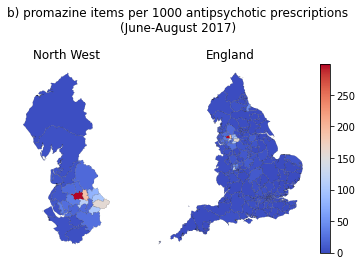

In [10]:
plt = ccg_map_bespoke(
    ccg_anti_psy, 
    title="b) promazine items per 1000 antipsychotic prescriptions\n(June-August 2017)", 
    map_year = '2018',
    column='promazine_per_1000_items', region='North West', separate_region=True,
    plot_options={'cmap': 'coolwarm'}
    )
exportfile = os.path.join("..","data","promazine_map.png")
plt.savefig(exportfile, dpi=300)

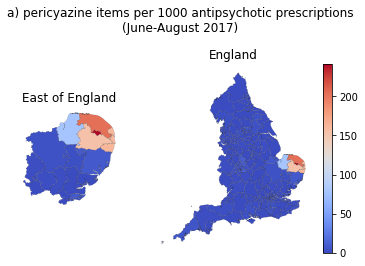

In [11]:
plt = ccg_map_bespoke(
    ccg_anti_psy, 
    title="a) pericyazine items per 1000 antipsychotic prescriptions\n(June-August 2017)", 
    map_year = '2018',
    column='pericyazine_per_1000_items', region='East of England', separate_region=True,
    plot_options={'cmap': 'coolwarm'}
    )
exportfile = os.path.join("..","data","pericyazine_map.png")
plt.savefig(exportfile, dpi=300)
